# Astra target landing site example

## Derivation of Nozzle lift equation (fixed ascent rate)

An estimate of the bounds of Nozzle lift is required for scipy's differential evolution algorithm. We'll use a primitive approach, since the method calculates (integrates) the ascent rate equation anyway, and a penalty method will be used for ascent rates reaching outside the desired boundaries.

Force balance:

\begin{equation}
(m_{bal} + m_{pay} + m_{gas}) \frac{d^2z}{dt^2} = B - W - D = 0\\
B = W + D\\
V(\rho_{air} - \rho_{gas}) g = (m_{bal} + m_{pay})g + \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D A
\end{equation}

Then use balloon volume to get a 3rd order polynomial in terms of $r$ (assuming balloon volume is constant throughout flight, due to fixed ascent rate assumption):

\begin{equation}
\frac{4}{3} \pi (\rho_{air} - \rho_{gas}) g r^3 - \frac{1}{2} \rho_{air} \left(\frac{dz}{dt}\right)^2 C_D \pi r^2 - (m_{bal} + m_{pay})g = 0
\end{equation}

Solve for r, and extract real positive root (should be unique: otherwise, raise an error). Then use the relation of gas mass (eqn 3 in "High-Altitude Gas Balloon Trajectory Prediction: A Monte Carlo Model") to obtain the nozzle lift:

\begin{equation}
m_{gas} = \rho^0_{gas} V^0 = \rho^0_{gas} \frac{L_N/g + m_{bal}}{\rho^0_{air} - \rho^0_{gas}}\\
L_N/g = \frac{4\pi}{3} r^3 (\rho_{air}-\rho_{gas}) - m_{bal} \hspace{1em} (kg)
\end{equation}

This is found in ```astra.flight_tools.nozzleLiftFixedAscent```, and has been validated with [habhub](http://habhub.org/calc/), which gives nozzle lift values of the same magnitude, and similar value (+- 10%)

## Ground distance equation

The Haversine formula is used to obtain ground distance $\Delta$ of the landing site from its target (assuming a spherical Earth), as

\begin{equation}
    \Delta = 2r\dot{}\mathrm{arcsin}\left( \sqrt{\mathrm{sin^2} \left( \frac{\phi_2 - \phi_1}{2}\right) + \mathrm{cos}(\phi_1) \mathrm{cos}(\phi_2) \mathrm{sin}^2 \left(\frac{\lambda_2 - \lambda_1}{2}\right)  }\right),
\end{equation}

where $\phi, \lambda$ refer to latitude and longitude respectively, and $r$ is the Earth's average radius ($=6371km$)

## 2D Optimization: Time + Nozzle Lift

In [1]:
%load_ext autoreload
%autoreload
import astra
from astra.target_landing import targetFlight
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from scipy.interpolate import interp1d
from astra.weather import forecastEnvironment
from astra.GFS import GFS_Handler
import astra
import os
%matplotlib notebook

In [3]:
targetLat = 51.077214
targetLon = -1.1866875398775423
targetElev = 137

# Use a previous forecast (allows offline development)
launch_datetime = datetime.today() + timedelta(days=1)
# simEnvironment = forecastEnvironment(launchSiteLat=50.903824,      # deg
#                                      launchSiteLon=-1.63697,     # deg
#                                      launchSiteElev=114.0,           # m
#                                      dateAndTime=launch_datetime,
#                                      forceNonHD=True,
#                                      debugging=True,
#                                      requestAll=False  # False has better memory overhead
#                                     )
# # Set up the example input data files (from 24/04/2017, Daytona Beach)
# fileDict = {}
# for paramName in GFS_Handler.weatherParameters.keys():
#     fileDict[paramName] = os.path.join(os.path.dirname(astra.__file__),
#         '../test/example_data',
#         'gfs_0p50_06z.ascii?{}[12:15][0:46][231:245][545:571]'.format(paramName))
# simEnvironment.loadFromNOAAFiles(fileDict)
# inputs = {'launchSiteForecasts': [simEnvironment]}

simulator = targetFlight(start_dateTime=launch_datetime,
                 targetLat=targetLat,
                 targetLon=targetLon,
                 targetElev=targetElev,
                 launchSites=[(50.903824, -1.63697, 114.0)],
                 balloonModel='TA100',
                 balloonGasType="Helium",
                 nozzleLift=1,
                 trainEquivSphereDiam=0.1,
                 inflationTemperature=0.0,
                 payloadTrainWeight=0.38,
                 windowDuration=72,
                 HD=False,
                 maxFlightTime=18000,
                 parachuteModel=None,
                 debugging=True,
                 log_to_file=False,
                 progress_to_file=False,
                 outputFile=os.path.join(''))

In [4]:
import copy
bestProfile_bf, X, Y, distances = simulator.bruteForce()
results_bf = copy.deepcopy(simulator.results)

DEBUG:astra.weather:Fetched time zone data about the launch site: UTC offset is 1.000000 hours
DEBUG:astra.weather:Using UTC time 17/06/17 16:55
INFO:astra.weather:Preparing to download weather data for parameters:
DEBUG:astra.weather:    Launch site Latitude: 50.903824
DEBUG:astra.weather:    Launch site Longitude: -1.63697
DEBUG:astra.weather:    Launch time: 2017-06-17 16:55:59.976415
DEBUG:astra.GFS:Attempting to download cycle data.


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_12z.ascii?tmpprs[9:34][0:46][263:301][0:719]
DEBUG:astra.GFS:GFS cycle not found.
DEBUG:astra.GFS:Moving to next cycle
DEBUG:astra.GFS:Attempting to download cycle data.


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_06z.ascii?tmpprs[11:36][0:46][263:301][0:719]
DEBUG:astra.GFS:Temperature data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_06z.ascii?hgtprs[11:36][0:46][263:301][0:719]
DEBUG:astra.GFS:Altitude data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_06z.ascii?ugrdprs[11:36][0:46][263:301][0:719]
DEBUG:astra.GFS:GFS cycle not found.
DEBUG:astra.GFS:Moving to next cycle
DEBUG:astra.GFS:Attempting to download cycle data.


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_00z.ascii?tmpprs[13:38][0:46][263:301][0:719]
DEBUG:astra.GFS:Temperature data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_00z.ascii?hgtprs[13:38][0:46][263:301][0:719]
DEBUG:astra.GFS:Altitude data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_00z.ascii?ugrdprs[13:38][0:46][263:301][0:719]
DEBUG:astra.GFS:U Winds data downloaded


DEBUG:astra.GFS:Requesting URL: http://nomads.ncep.noaa.gov:9090/dods/gfs_0p50/gfs20170616/gfs_0p50_00z.ascii?vgrdprs[13:38][0:46][263:301][0:719]
DEBUG:astra.GFS:V Winds data downloaded


Weather downloaded.


DEBUG:astra.GFS:Forecast successfully downloaded!
DEBUG:astra.weather:GFS data successfully downloaded.
INFO:astra.target_landing:Date range: [2017-06-17 17:55:59.976415, 2017-06-20 17:55:59.976415], Nx=19 points
INFO:astra.target_landing:Nozzle Lift range: [0.41604821396915026, 1.7128711861717523] (kg), Ny=21 points
DEBUG:astra.target_landing:Running brute force calculation
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 17:55:59.976415, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 17:55:59.976415, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 17:55:59.976415, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 17:55:59.976415, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-17 17:55:59.976415, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for 

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=1.0644597000704512kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=1.1293008486805813kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.976415, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 05:55:59.97641

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.3238242945109717kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.6480300375616221kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 17:55:59.976415, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 21:55:59.976415, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 21:55:59.97641

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.8699362542400609kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.9347774028501911kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.976415, nozzleLift=0.9996185514603212kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:55:59.97641

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.1293008486805813kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.1941419972907115kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.2589831459008416kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.3238242945109717kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.3886654431211016kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.453506591731232kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.5183477403413619kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415, nozzleLift=1.5831888889514922kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 21:55:59.976415

DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 09:55:59.976415, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.4808893625792804kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.5457305111894104kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.6105716597995405kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.6754128084096707kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.7402539570198008kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.976415, nozzleLift=0.8050951056299309kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 13:55:59.9764

In [ ]:
# Visualise the best result paths
simulator.plotPaths3D()

(19,) (21,) (19, 21)


<IPython.core.display.Javascript object>


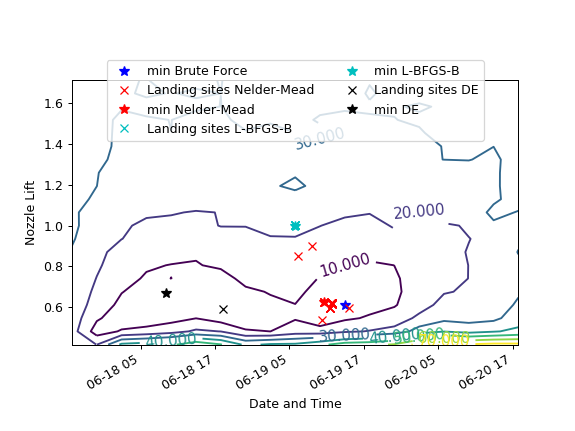

In [22]:
%autoreload
import astra

# fig2, ax2 = simulator.plotLandingSites()
simulator.results = results_bf
simulator.bestProfile = bestProfile_bf
print(np.shape(X), np.shape(Y), np.shape(distances))
fig3, ax3 = simulator.plotLandingSiteDistanceContours(X, Y, distances.T, appendLabel=' Brute Force')


## Nelder Mead Simplex Algorithm

In [ ]:
%autoreload
import astra

In [6]:
# Optimize with Scipy:
res_scipy = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0], options={"disp": True})
bestProfile_scipy = simulator.bestProfile
results_scipy = simulator.results
Xs_scipy = simulator.Xs

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 07:43:59.976415, nozzleLift=1.0kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.05kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 07:43:59.976415, nozzleLift=0.95kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 08:37:59.976415, nozzleLift=0.8999999999999999kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:49:59.976415, nozzleLift=0.8999999999999999kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 06:22:59.976415, nozzleLift=0.8499999999999996kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:04:59.976415, nozzleLift=0.7499999999999996kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 10:39:29.976415, nozzleLift=0.6249999999999991kg
DEBUG:astra.target_land

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:45.797973, nozzleLift=0.6183247842360278kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:39.311611, nozzleLift=0.6183503911364814kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:35.821789, nozzleLift=0.618352259043603kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:38.315835, nozzleLift=0.6183453903417092kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:35.319296, nozzleLift=0.6183691293350412kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:40.560937, nozzleLift=0.6183372714411224kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:38.813723, nozzleLift=0.6183478907390954kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:40.809881, nozzleLift=0.6183385216398154kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 11:49:37.315454

Optimization terminated successfully.
         Current function value: 0.060193
         Iterations: 45
         Function evaluations: 109


In [23]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_scipy
simulator.results = results_scipy
simulator.Xs = Xs_scipy
simulator.plotLandingSiteDistances(fig3, ax3, marker='rx', bestMarker='r*', appendLabel=' Nelder-Mead')

(<matplotlib.figure.Figure at 0x7fb6d242dc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d0b62c50>)

In [ ]:
print(res_scipy)

## L-BFGS-B Algorithm

In [8]:
from astra.flight_tools import nozzleLiftFixedAscent

# Optimize with Scipy:
start_timedelta = 0
end_timedelta = simulator.windowDuration

nozzleLiftLowerBound = nozzleLiftFixedAscent(simulator.minAscentRate,
                simulator._balloonWeight, simulator.payloadTrainWeight,
                simulator.environment.inflationTemperature,
                simulator.environment.getPressure(simulator.launchSiteLat,
                                                  simulator.launchSiteLon,
                                                  simulator.launchSiteElev,
                                                  simulator.start_dateTime),
                simulator._gasMolecularMass, simulator.excessPressureCoeff,
                CD=(0.225 + 0.425)/2.)
nozzleLiftUpperBound = nozzleLiftFixedAscent(simulator.maxAscentRate,
                simulator._balloonWeight, simulator.payloadTrainWeight,
                simulator.environment.inflationTemperature,
                simulator.environment.getPressure(simulator.launchSiteLat,
                                                  simulator.launchSiteLon,
                                                  simulator.launchSiteElev,
                                                  simulator.start_dateTime),
                simulator._gasMolecularMass, simulator.excessPressureCoeff,
                CD=(0.225 + 0.425)/2.)

res_lbfgsb = simulator.optimizeTargetLandingSite(x0=[0.5*simulator.windowDuration, 1.0],
                                                 method='L-BFGS-B',
                                                 bounds=([start_timedelta, end_timedelta],
                                                         [nozzleLiftLowerBound, nozzleLiftUpperBound]),
                                                 options={"disp": True, "maxfun":200},
                                                 )
bestProfile_lbfgsb = simulator.bestProfile
results_lbfgsb = simulator.results
Xs_lbfgsb = simulator.Xs

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.00000001kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.7128711861717523kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.7128711961717522kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.2377999402918984kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.2377999402918984kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.2377999502918984kg
DEB

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458886278644kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007458886278644kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458986278643kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.000740842684102kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.000740842684102kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.000740852684102kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.000744214736121kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.000744214736121kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, no

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.000745882006692kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.000745882006692kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458920066918kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458864327978kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007458864327978kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458964327978kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.000745888166033kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.000745888166033kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, n

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458885566238kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007458885566238kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458985566238kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458885962053kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007458885962053kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458985962052kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007458886044365kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007458886044365kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.97641

DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007426151358483kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007426151358483kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007426251358482kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007448042860456kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007448042860456kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007448142860456kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976415, nozzleLift=1.0007455316773632kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.976451, nozzleLift=1.0007455316773632kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 05:55:59.97641

In [24]:
# Optimize with scipy differential evolution
simulator.bestProfile = bestProfile_lbfgsb
simulator.results = results_lbfgsb
simulator.Xs = Xs_lbfgsb
simulator.plotLandingSiteDistances(fig3, ax3, marker='cx', bestMarker='c*', appendLabel=' L-BFGS-B')

(<matplotlib.figure.Figure at 0x7fb6d242dc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d0b62c50>)

In [10]:
print(res_lbfgsb)

      fun: 20.764872355466544
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([      0.        ,  915715.44335665])
  message: b'ABNORMAL_TERMINATION_IN_LNSRCH'
     nfev: 315
      nit: 5
   status: 1
  success: False
        x: array([ 36.        ,   1.00074589])


## Scipy differential Evolution

In [14]:
%autoreload
import astra

res_de = simulator.optimizeTargetLandingSite(method='DE', tol=1, maxiter=6)
results_de = simulator.results
bestProfile_de = simulator.bestProfile
Xs_de = simulator.Xs

DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 12:31:57.290685, nozzleLift=1.2062603679186856kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 20:22:56.201562, nozzleLift=0.5413558519745832kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 18:28:56.532464, nozzleLift=1.3172392540695799kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 01:49:44.991378, nozzleLift=1.6929316371986438kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-20 06:18:56.419031, nozzleLift=1.5019363520046114kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 13:33:51.457741, nozzleLift=1.1492134481964023kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 09:12:35.973917, nozzleLift=1.043432513770081kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-19 10:23:35.802503, nozzleLift=0.8793202823136825kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 09:04:21.923510

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5920441217453848kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5920441217453848kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5920441317453848kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.8147270416669591kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.8147270416669591kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.8147270516669591kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.6641590721153234kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.6641590721153234kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.71633

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020568656851kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5926020568656851kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020668656852kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020568656851kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5926020568656851kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020668656852kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.41604821396915026kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716

DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020561399092kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5926020561399092kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020661399093kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020562032763kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5926020562032763kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020662032764kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716336, nozzleLift=0.5926020562034284kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.716372, nozzleLift=0.5926020562034284kg
DEBUG:astra.target_landing:Running flight for datetime 2017-06-18 18:14:59.71633

In [30]:
res_de

     fun: 2.2959521616369303
     jac: array([   0.        ,  250.56244621])
 message: 'Optimization terminated successfully.'
    nfev: 285
     nit: 1
 success: True
       x: array([ 24.31659442,   0.59260206])

In [25]:
simulator.results = results_de
simulator.bestProfile = bestProfile_de
simulator.Xs = Xs_de
simulator.plotLandingSiteDistances(fig3, ax3, marker='kx', bestMarker='k*', appendLabel=' DE')

(<matplotlib.figure.Figure at 0x7fb6d242dc88>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fb6d0b62c50>)

In [31]:
fig3.savefig('Distance2D_NozzleLift_LaunchTime.pdf')

In [27]:
Nx = simulator.windowDuration / 4 + 1
Ny = 21
print("Brute Force: delta={}, nevals={}".format(bestProfile_bf.distanceFromTarget, Nx * Ny))
print("Differential Evolution: delta={}, nevals={}".format(bestProfile_de.distanceFromTarget), res_de.nfev)
print("Nelder Mead: {}, nevals={}".format(bestProfile_scipy.distanceFromTarget, res_scipy.nfev))

Brute Force: 2.4147840299412313
Differential Evolution: 5.391709571384392
Nelder Mead: 3.3329091951969203


## Testing

In [ ]:
 datetimeVector = [self.start_dateTime + timedelta(hours=t)
                            for t in range(self.windowDuration)]

nozzleLiftLowerBound = 0.4
nozzleLiftUpperBound = 1.0
nozzelLift_Vector = np.linspace(nozzleLiftLowerBound, nozzleLiftUpperBound)
self.results = {}

distance_map = {}
for i, launchSiteForecast in enumerate(self.launchSiteForecasts):
    self.environment = launchSiteForecast

    for j, t in enumerate(datetimeVector):
        distance_lift_vec = np.zeros(np.length(nozzelLift_Vector))
        for k, L in enumerate(nozzelLift_Vector):
            # brute force approach
            distance = self.targetDistance(t)
            distance_lift_vec[k] = distance

        distance_map[t] = distance_Vector  